In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('book.log', header=None, names=['TYPE', 'TIME', 'a', 'b', 'c', 'd', 'e', 'f'])

In [2]:
orders_df = df[df['TYPE'] == 'ORDER BOOK'][['TYPE', 'TIME', 'a', 'b', 'c', 'd']]
orders_df.columns = ['TYPE', 'TIME', 'DIR', 'PRICE', 'QUANTITY', 'OrderID']

trade_df = df[df['TYPE'] == 'TRADE']
trade_df.columns = ['TYPE', 'TIME', 'TICKER', 'PRICE', 'QUANTITY', 'Buy?', 'RestingID', 'AggID']
trade_df['PRICE'] = trade_df['PRICE'].astype(float)

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
## generate bbo + other core data

best_bids = orders_df.loc[orders_df[orders_df["DIR"] == "BID"].groupby(["TIME"])["PRICE"].idxmax()]
best_bids = best_bids[['TIME', 'PRICE', 'QUANTITY', 'OrderID']]
best_bids.columns = ['TIME', 'BB', 'BB_size', 'BB_OrderID']

best_offers = orders_df.loc[orders_df[orders_df["DIR"] == "OFFER"].groupby(["TIME"])["PRICE"].idxmin()]
best_offers = best_offers[['TIME', 'PRICE', 'QUANTITY', 'OrderID']]
best_offers.columns = ['TIME', 'BO', 'BO_size', 'BO_OrderID']

bbo_df = best_bids.merge(best_offers, on="TIME", how="outer")
bbo_df.head()

,TIME,BB,BB_size,BB_OrderID,BO,BO_size,BO_OrderID
0,1524625148475501,99.71,10970.0,1.053641e+18,NaN,NaN,NaN
1,1524625148547915,99.72,11047.0,1.518087e+19,NaN,NaN,NaN
2,1524625148565180,99.73,10132.0,1.338557e+19,NaN,NaN,NaN
3,1524625148575684,99.75,6400.0,1.398005e+18,NaN,NaN,NaN
4,1524625148586351,99.77,3901.0,3.290692e+18,NaN,NaN,NaN


In [4]:
bbo_df['Spread'] = bbo_df['BO'] - bbo_df['BB']
bbo_df['swmid'] = (bbo_df['BB'] * bbo_df['BO_size'] + bbo_df['BO'] * bbo_df['BB_size']) / (bbo_df['BO_size'] + bbo_df['BB_size'])

## calculate Pnls to swmid

def get_swmid(t):
    ## gets swmid at next time >= t
    idx = np.searchsorted(bbo_df['TIME'], t)
    return bbo_df['swmid'].values[idx-1]

deltas = [int(1e9), int(5e8), int(1e8), int(5e7)]
for delta in deltas:
    bbo_df[str(delta)+"_pnl_to_swmid"] = [get_swmid(t+delta)-swmid for t,swmid in 
                                          zip(bbo_df['TIME'], bbo_df['swmid'])] # assumes buying
bbo_df

,TIME,BB,BB_size,BB_OrderID,BO,BO_size,BO_OrderID,Spread,swmid,1000000000_pnl_to_swmid,500000000_pnl_to_swmid,100000000_pnl_to_swmid,50000000_pnl_to_swmid
0,1524625148475501,99.71,10970.0,1.053641e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1524625148547915,99.72,11047.0,1.518087e+19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1524625148565180,99.73,10132.0,1.338557e+19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1524625148575684,99.75,6400.0,1.398005e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1524625148586351,99.77,3901.0,3.290692e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1524625148597937,99.79,2736.0,8.522283e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1524625148613331,99.79,2736.0,8.522283e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1524625148627958,99.82,476.0,1.431480e+19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1524625148642597,99.83,345.0,1.075830e+19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1524625148658969,99.84,454.0,2.709913e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
orders_df.tail()

,TYPE,TIME,DIR,PRICE,QUANTITY,OrderID
1013527,ORDER BOOK,1524640541168342,BID,99.07,564,9919441716232564910
1013528,ORDER BOOK,1524640541168342,BID,99.07,5250,11196765491904928027
1013529,ORDER BOOK,1524640541168342,BID,99.06,1627,8226010819773955069
1013530,ORDER BOOK,1524640541168342,BID,99.06,5480,10023695590083565831
1013531,ORDER BOOK,1524640541168342,BID,99.06,5737,37871881213223371


In [6]:
trade_df.head()

,TYPE,TIME,TICKER,PRICE,QUANTITY,Buy?,RestingID,AggID
495,TRADE,1524625149278387,NaN,99.85,219,0,9573207825680514865,13247672426123479393
526,TRADE,1524625149327306,NaN,99.85,203,0,9573207825680514865,13587701704998446626
1805,TRADE,1524625150872898,NaN,100.12,205,1,11768694736966851967,13458537775586450985
4378,TRADE,1524625166722467,NaN,100.17,229,1,13093300511415373197,18007800703523332916
4410,TRADE,1524625166811072,NaN,99.87,229,0,1341470531459205116,6277292905652929367


In [7]:
len(orders_df), len(trade_df), len(bbo_df)

(1010565, 2968, 27905)

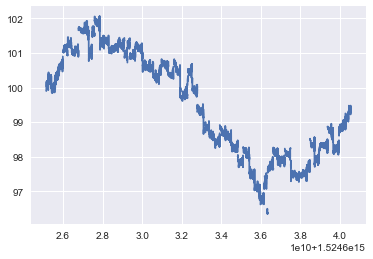

In [8]:
plt.plot(bbo_df['TIME'], bbo_df['swmid'])

## test out 30k trades

In [9]:
trades_30k_idx = orders_df["QUANTITY"] == 30000
sum(trades_30k_idx)

4120

In [10]:
trades_30k_ids = orders_df[trades_30k_idx]['OrderID']
trades_30k_ids.unique()

array([15381033710779307233,  1341470531459205116, 12871042225177499223,
       10824637502072770697,  8762858621189033258,   652915309499002462,
        5751644230670108429,  3861486087564063852,  2303260012132234321,
        8525841494919820137, 15775531201868180452,  3854316188996953448,
       11218169170487918826,  4968050627306382015, 16113549276172076255,
       15250280476740010811, 14140109267418311323,  4088034371368171573,
        1377737209983058648,  4800659782619706278, 13243178230553070698,
        5291330352124911281, 13023993581243327016, 11919823229230013517,
        3498617610817214941,  5883099573680968910,  4800695446662656354,
        9494288807086937295,  6404177344922104364,    10780985536901676,
        6100670490513003439,  1401837920625183324,  1473000724673453545,
        3852051189713181401, 13232397502599220500, 11055005249926891163,
       13254957748933078186, 12795283879558430365,  4491781850617479157,
        1442679820015558625,  2631853429918472622, 

In [11]:
orders_df[orders_df['OrderID'] == 1401837920625183324]

,TYPE,TIME,DIR,PRICE,QUANTITY,OrderID
132457,ORDER BOOK,1524626047481165,BID,100.86,30000,1401837920625183324
132489,ORDER BOOK,1524626048076245,BID,100.86,30000,1401837920625183324
132522,ORDER BOOK,1524626048129547,BID,100.86,30000,1401837920625183324
132554,ORDER BOOK,1524626048225434,BID,100.86,30000,1401837920625183324
132587,ORDER BOOK,1524626048323750,BID,100.86,30000,1401837920625183324
132620,ORDER BOOK,1524626048423146,BID,100.86,30000,1401837920625183324
132654,ORDER BOOK,1524626049015927,BID,100.86,30000,1401837920625183324
132689,ORDER BOOK,1524626052079115,BID,100.86,30000,1401837920625183324
132725,ORDER BOOK,1524626052207815,BID,100.86,30000,1401837920625183324
132761,ORDER BOOK,1524626052261243,BID,100.86,30000,1401837920625183324


In [12]:
all_pnls = []
deltas = [int(1e9), int(5e8), int(3e8), int(2e8), int(1e8), int(3e7), int(1e7), int(3e6)]

for OrderID in orders_df[trades_30k_idx]['OrderID'].unique():
    ## signal 
    start_time = orders_df[orders_df['OrderID'] == OrderID]['TIME'].min()
    end_time = orders_df[orders_df['OrderID'] == OrderID]['TIME'].max()
    
    ## pnl to different points
    this_pnl = [start_time, orders_df[orders_df['OrderID'] == OrderID]['DIR'].iloc[0]]
    for delta in deltas + [end_time-start_time]:
        this_pnl.append(get_swmid(start_time+delta) - get_swmid(start_time))
    
    all_pnls.append(this_pnl)
    
pnl_30k_df = pd.DataFrame(all_pnls)
pnl_30k_df.columns = ['TIME', 'DIR'] + ['PNL_{}'.format(delta) for delta in deltas] + ['PNL_to_end']
pnl_30k_df['Buy?'] = (pnl_30k_df['DIR'] == 'BID') * 2 - 1

In [13]:
pnl_30k_df

,TIME,DIR,PNL_1000000000,PNL_500000000,PNL_300000000,PNL_200000000,PNL_100000000,PNL_30000000,PNL_10000000,PNL_3000000,PNL_to_end,Buy?
0,1524625150748965,BID,1.188604,0.369100,-0.141921,0.070269,0.248029,0.138306,0.122435,-0.051781,0.000000,1
1,1524625150946943,BID,1.147231,0.327728,-0.183294,0.028896,0.206657,0.096934,0.081062,-0.093154,0.093913,1
2,1524625340844254,OFFER,0.895345,0.360916,0.108283,-0.227172,-0.369349,-0.215944,-0.196079,-0.184953,0.000000,-1
3,1524625340973250,OFFER,0.895345,0.360916,0.108283,-0.227172,-0.369349,-0.215944,-0.196079,-0.184953,-0.170910,-1
4,1524625341655348,OFFER,0.895345,0.360916,0.108283,-0.227172,-0.442062,-0.215944,-0.196079,-0.194115,0.000000,-1
5,1524625341820786,OFFER,0.895345,0.360916,0.098427,-0.227172,-0.442062,-0.215944,-0.196079,-0.194115,0.000000,-1
6,1524625341954296,OFFER,0.895345,0.360916,0.098629,-0.227172,-0.442062,-0.215944,-0.196079,-0.194115,0.000000,-1
7,1524625342106145,OFFER,0.895345,0.360916,-0.094467,-0.227172,-0.442062,-0.215944,-0.196079,-0.194115,-0.174826,-1
8,1524625342463676,OFFER,0.971126,0.436697,0.174572,-0.151390,-0.366280,-0.140162,-0.120297,-0.118333,-0.118333,-1
9,1524625346435897,OFFER,0.907293,0.383355,-0.041163,-0.214165,-0.395262,-0.203010,-0.183072,-0.183072,-0.181296,-1


C:\Users\George\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


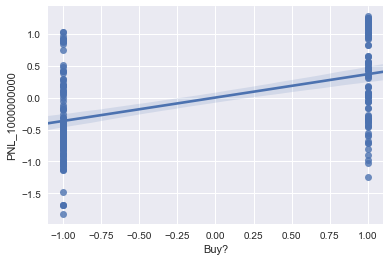

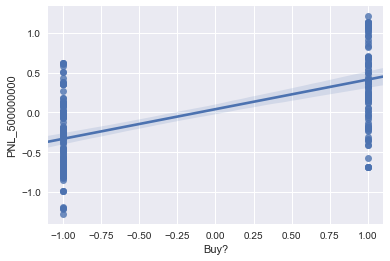

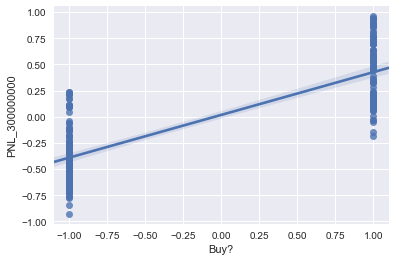

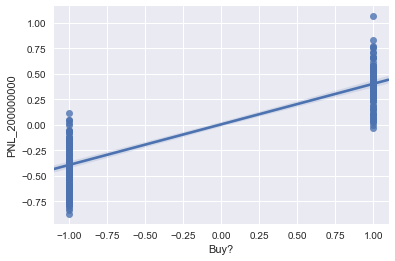

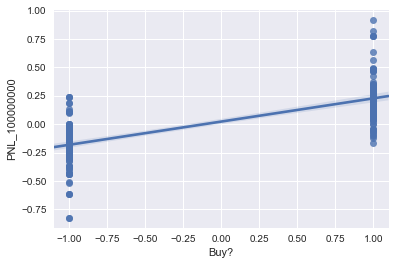

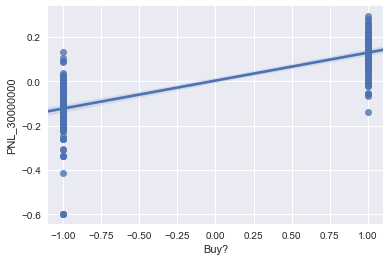

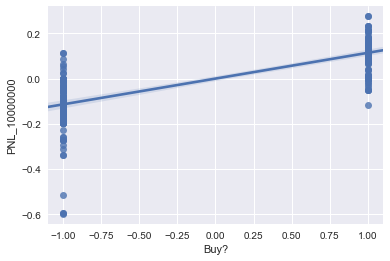

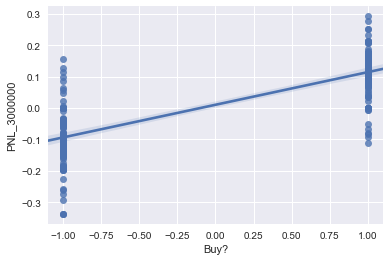

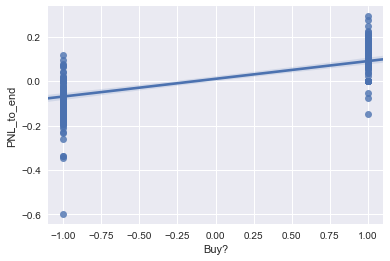

In [14]:
## corr plots
for pnl_option in pnl_30k_df.columns:
    if pnl_option[:3] == 'PNL':
        sns.regplot(pnl_30k_df['Buy?'], pnl_30k_df[pnl_option])
        plt.show()

In [15]:
## backtest strategy

start_times = []
dirs = 
for OrderID in orders_df[trades_30k_idx]['OrderID'].unique():
    ## signal 
    start_times.append(orders_df[orders_df['OrderID'] == OrderID]['TIME'].min())
    
start_times


SyntaxError: invalid syntax (<ipython-input-15-13e7cb5448cf>, line 4)

### look at taking volume over past X seconds

In [28]:
trade_df['NET_VOL'] = (2*trade_df['Buy?'].astype(int) - 1) * trade_df['QUANTITY']

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
def net_vol(t1, t2):
    ## computes vol between t1 and t2
    return trade_df[(trade_df['TIME'] >= t1) & (trade_df['TIME'] < t2)]['NET_VOL'].sum()

for delta in [int(1e8), int(3e7), int(1e7), int(3e6), int(1e6), int(3e5), int(1e5)]:
    bbo_df['NET_VOL_'+str(delta)] = [net_vol(t, t+delta) for t in bbo_df["TIME"]]

In [33]:
bbo_df

,TIME,BB,BB_size,BB_OrderID,BO,BO_size,BO_OrderID,Spread,swmid,1000000000_pnl_to_swmid,...,NET_VOL_500000000,NET_VOL_300000000,NET_VOL_200000000,NET_VOL_100000000,NET_VOL_30000000,NET_VOL_10000000,NET_VOL_3000000,NET_VOL_1000000,NET_VOL_300000,NET_VOL_100000
0,1524625148475501,99.71,10970.0,1.053641e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
1,1524625148547915,99.72,11047.0,1.518087e+19,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
2,1524625148565180,99.73,10132.0,1.338557e+19,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
3,1524625148575684,99.75,6400.0,1.398005e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
4,1524625148586351,99.77,3901.0,3.290692e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
5,1524625148597937,99.79,2736.0,8.522283e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
6,1524625148613331,99.79,2736.0,8.522283e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
7,1524625148627958,99.82,476.0,1.431480e+19,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
8,1524625148642597,99.83,345.0,1.075830e+19,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0
9,1524625148658969,99.84,454.0,2.709913e+18,NaN,NaN,NaN,NaN,NaN,NaN,...,7.501553e+23,6.612789e+23,1.303078e+23,19901,-1678,-217,-217,-422,0,0


C:\Users\George\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


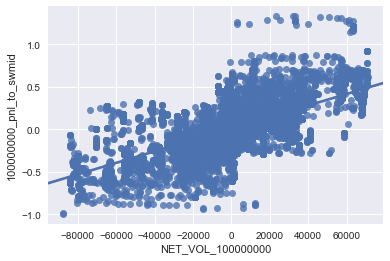

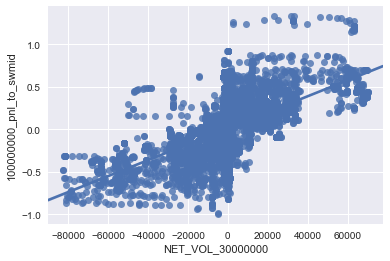

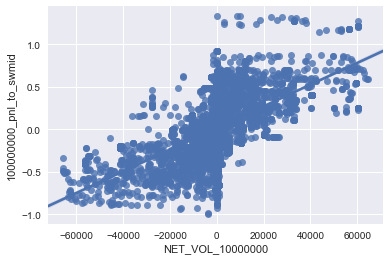

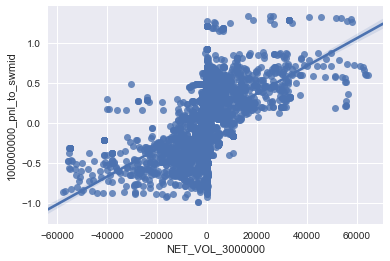

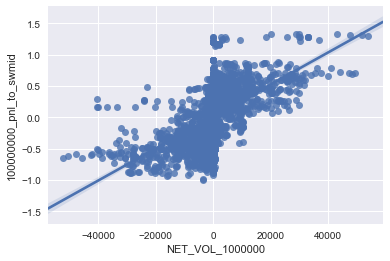

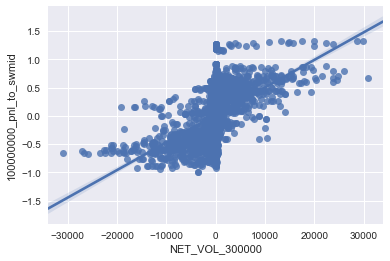

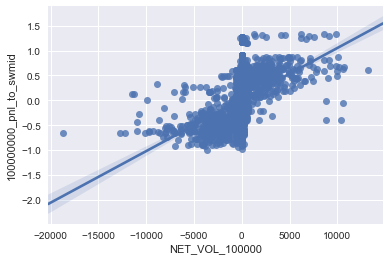

In [35]:
deltas = [int(1e8), int(3e7), int(1e7), int(3e6), int(1e6), int(3e5), int(1e5)]

for delta in deltas:
    sns.regplot(bbo_df['NET_VOL_'+str(delta)], bbo_df['100000000_pnl_to_swmid'])
    plt.show()

10000


C:\Users\George\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


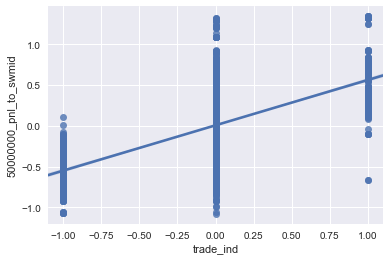

5000


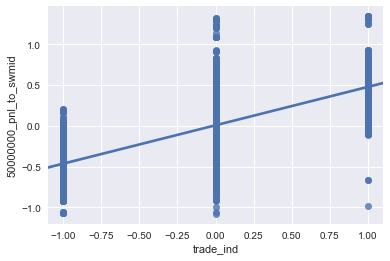

3000


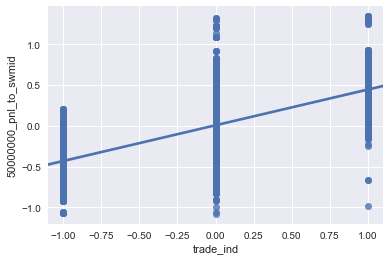

1000


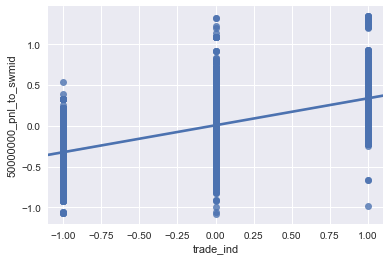

500


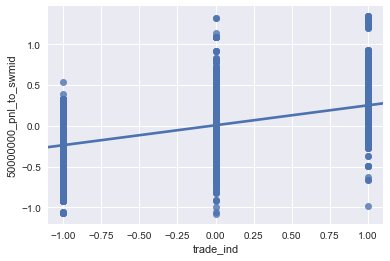

100


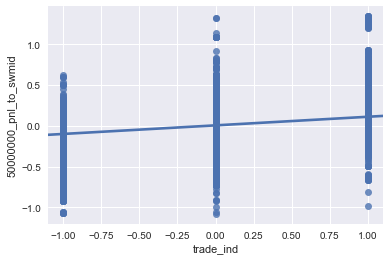

In [53]:
for threshold in [10000,5000,3000,1000,500,100]:
    print(threshold)
    bbo_df['trade_ind'] = (bbo_df['NET_VOL_1000000'] > threshold) + (-1) * (bbo_df['NET_VOL_1000000'] < -threshold)
    sns.regplot(bbo_df['trade_ind'], bbo_df[str(int(5e7)) + '_pnl_to_swmid'])
    plt.show()

In [84]:
temp_df = orders_df.loc[orders_df[trades_30k_idx].groupby('OrderID')['TIME'].idxmin()]
temp_df['trade_ind2'] = (temp_df['DIR'] == 'BID') * 2 - 1
temp_df.head()

,TYPE,TIME,DIR,PRICE,QUANTITY,OrderID,trade_ind2
772592,ORDER BOOK,1524636726493027,OFFER,98.29,30000,8000681827901949,-1
99176,ORDER BOOK,1524625836314292,BID,100.41,30000,10780985536901676,1
719588,ORDER BOOK,1524635925359951,OFFER,97.15,30000,21263295082965981,-1
358611,ORDER BOOK,1524629777053683,OFFER,101.32,30000,48757554981007533,-1
694177,ORDER BOOK,1524635525188930,OFFER,97.66,30000,220387448797886699,-1


In [80]:
threshold = 3000
bbo_df['trade_ind1'] = (bbo_df['NET_VOL_1000000'] > threshold) + (-1) * (bbo_df['NET_VOL_1000000'] < -threshold)

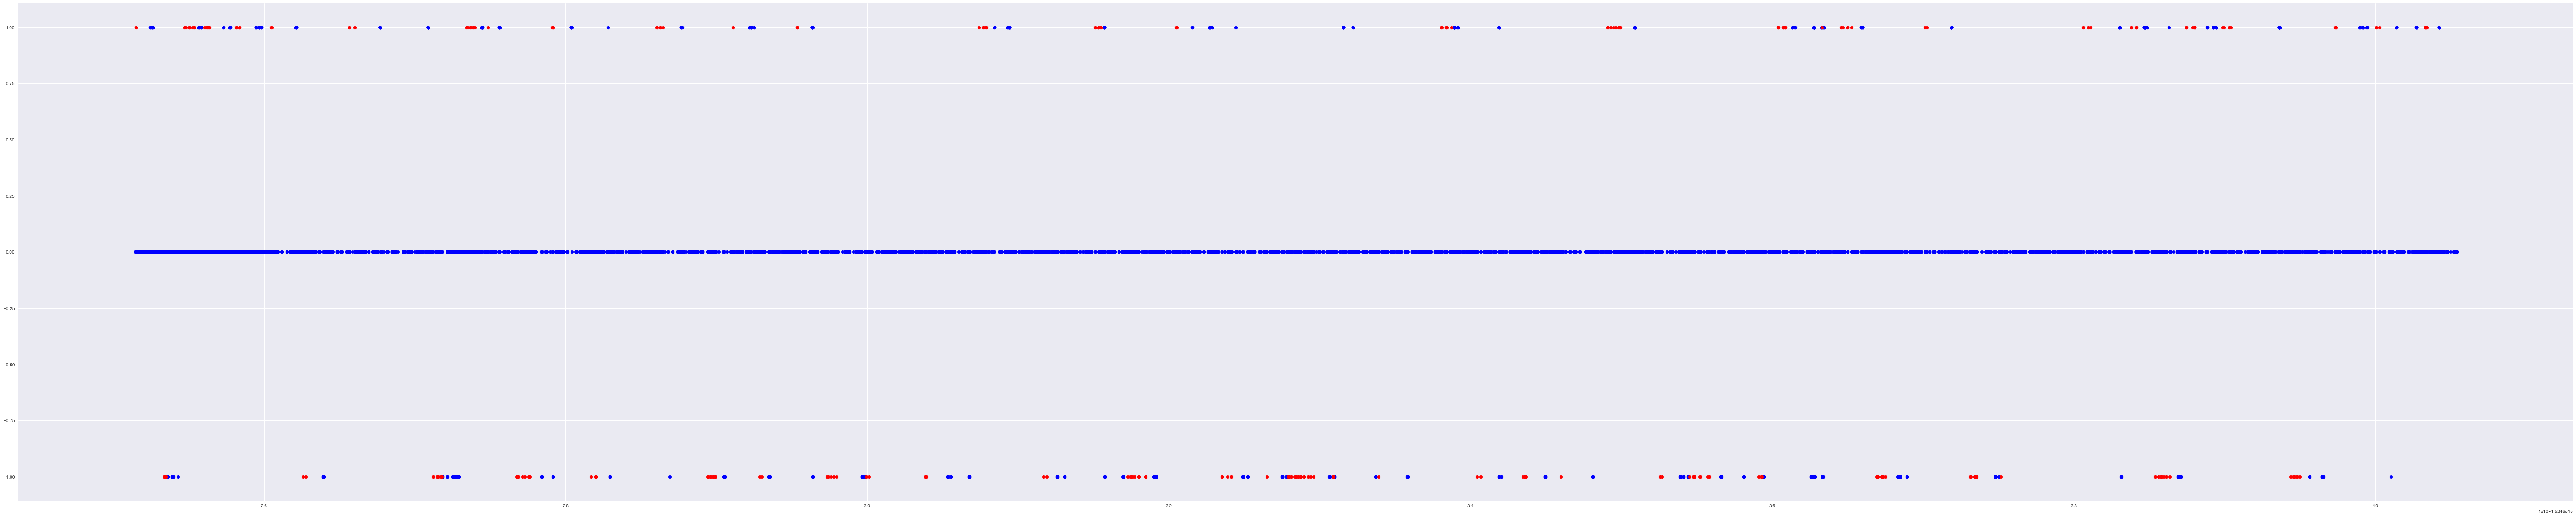

In [87]:
plt.figure(figsize=(100,20))
plt.scatter(bbo_df['TIME'], bbo_df['trade_ind1'], c='b')
plt.scatter(temp_df['TIME'], temp_df['trade_ind2'], c='r')

## Investigate spread + market-making

(array([4.804e+03, 1.123e+03, 1.092e+03, 6.980e+02, 8.970e+02, 7.550e+02,
        4.740e+02, 1.013e+03, 2.251e+03, 2.433e+03, 3.434e+03, 2.843e+03,
        3.245e+03, 7.130e+02, 5.860e+02, 3.000e+02, 8.100e+01, 8.900e+01,
        3.800e+01, 1.000e+01, 8.000e+00, 7.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([0.01 , 0.037, 0.064, 0.091, 0.118, 0.145, 0.172, 0.199, 0.226,
        0.253, 0.28 , 0.307, 0.334, 0.361, 0.388, 0.415, 0.442, 0.469,
        0.496, 0.523, 0.55 , 0.577, 0.604, 0.631, 0.658, 0.685, 0.712,
        0.739, 0.766, 0.793, 0.82 , 0.847, 0.874, 0.901, 0.928, 0.955,
        0.982, 1.009, 1.036, 1.063, 1.09 ]),
 <a list of 40 Patch objects>)

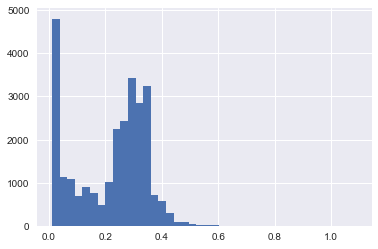

In [95]:
plt.hist(bbo_df['Spread'].dropna(), bins=40)